## Deadline

Wednesday, November 22, 2017, 11:59PM

## Important notes

- When you push your Notebook to GitHub, all the cells must already have been evaluated.
- Don't forget to add a textual description of your thought process and of any assumptions you've made.
- Please write all your comments in English, and use meaningful variable names in your code.

## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.tools.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline

In [3]:
file = 'lalonde.csv'

In [4]:
lalonde = pd.read_csv(file, )

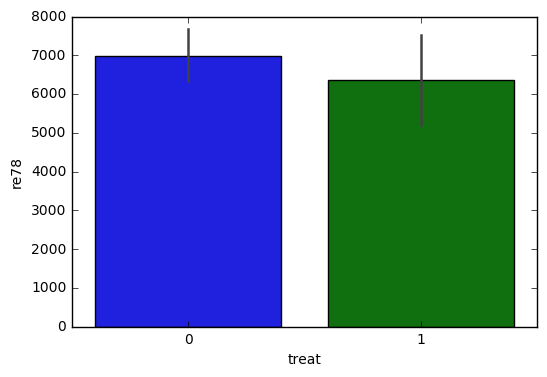

In [8]:
sns.barplot(x='treat', y='re78', data=lalonde)

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.



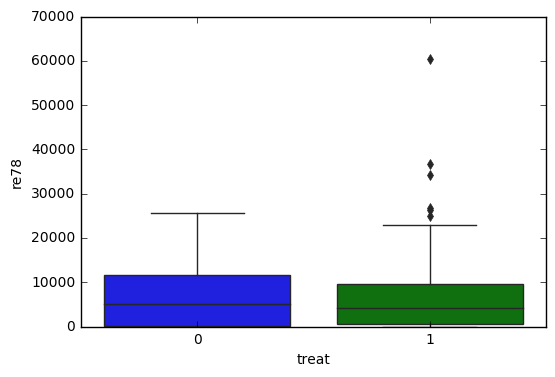

In [14]:
sns.boxplot(x='treat', y='re78', data=lalonde)

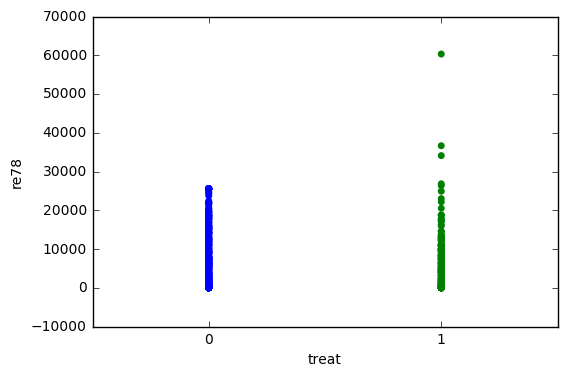

In [15]:
sns.stripplot(x='treat', y='re78', data=lalonde)

#### 3. A propsensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)



In [5]:
print(lalonde.head())

     id  treat  age  educ  black  hispan  married  nodegree  re74  re75  \
0  NSW1      1   37    11      1       0        1         1   0.0   0.0   
1  NSW2      1   22     9      0       1        0         1   0.0   0.0   
2  NSW3      1   30    12      1       0        0         0   0.0   0.0   
3  NSW4      1   27    11      1       0        0         1   0.0   0.0   
4  NSW5      1   33     8      1       0        0         1   0.0   0.0   

         re78  
0   9930.0460  
1   3595.8940  
2  24909.4500  
3   7506.1460  
4    289.7899  


In [6]:
from sklearn.preprocessing import normalize
x = lalonde.drop(['id', 're78'], axis=1)
logistic = LogisticRegression()
logistic.fit(X=x, y=lalonde['treat'])
propensity = logistic.predict_proba(x)
print(propensity)

[[ 0.12210616  0.87789384]
 [ 0.14815303  0.85184697]
 [ 0.04387151  0.95612849]
 ..., 
 [ 0.99064868  0.00935132]
 [ 0.88450024  0.11549976]
 [ 0.96555324  0.03444676]]


In [13]:
len(propensity)

614

#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

---

We use a node attribute named “bipartite” with values 0 or 1 to identify the sets each node belongs to.



In [7]:
import networkx as nx

In [12]:
# Graph initialization
B = nx.Graph()

# Split the ids between treated and non treated
treated = lalonde.loc[lalonde['treat'] == 1].id
not_treated = lalonde.loc[lalonde['treat'] == 0].id

# Add the two sets of ids in the bipartite graph
B.add_nodes_from(treated, bipartite = 1)
B.add_nodes_from(not_treated, bipartite = 0)

# Split the propensity scores between treated and not treated
score_treated = propensity[np.where(lalonde['treat'] == 1)[0]]
score_nontreated = propensity[np.where(lalonde['treat'] == 0)[0]]


for i, st in enumerate(score_treated):
    for j, sn in enumerate(score_nontreated):
        B.add_edge(treated.iloc[i], not_treated.iloc[j], weight = np.abs(st - sn))
        

matching = nx.bipartite.maximum_matching(B)
print(len(matching))

370


In [18]:
print(matching)

{'NSW45': 'PSID198', 'NSW177': 'PSID272', 'PSID198': 'NSW45', 'PSID121': 'NSW151', 'NSW24': 'PSID111', 'PSID200': 'NSW28', 'PSID111': 'NSW24', 'PSID47': 'NSW152', 'NSW167': 'PSID284', 'PSID209': 'NSW68', 'NSW144': 'PSID64', 'NSW63': 'PSID137', 'NSW163': 'PSID274', 'PSID271': 'NSW149', 'NSW17': 'PSID286', 'NSW151': 'PSID121', 'PSID9': 'NSW5', 'NSW16': 'PSID402', 'NSW134': 'PSID51', 'PSID284': 'NSW167', 'PSID202': 'NSW137', 'PSID299': 'NSW54', 'PSID161': 'NSW72', 'NSW50': 'PSID127', 'NSW115': 'PSID43', 'NSW85': 'PSID165', 'PSID64': 'NSW144', 'NSW183': 'PSID287', 'NSW117': 'PSID318', 'PSID101': 'NSW106', 'PSID306': 'NSW52', 'PSID286': 'NSW17', 'PSID272': 'NSW177', 'PSID71': 'NSW4', 'PSID402': 'NSW16', 'NSW93': 'PSID114', 'NSW60': 'PSID363', 'PSID93': 'NSW69', 'NSW66': 'PSID169', 'NSW101': 'PSID408', 'PSID292': 'NSW61', 'NSW94': 'PSID343', 'NSW89': 'PSID264', 'PSID281': 'NSW65', 'PSID397': 'NSW78', 'NSW131': 'PSID150', 'NSW162': 'PSID214', 'PSID43': 'NSW115', 'PSID134': 'NSW34', 'PSID165':

In [48]:
matched_left = matching.keys()
matched_right = matching.values()
reduced_lalonde = lalonde.set_index('id')
reduced_ids = np.concatenate((np.array(list(matched_left)), np.array(list(matched_right))), axis=0)
reduced_lalonde.head()
reduced_lalonde = reduced_lalonde.loc[list(set(reduced_ids))]

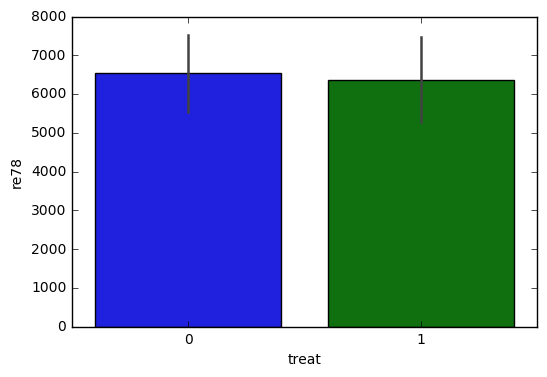

In [49]:
sns.barplot(x='treat', y='re78', data=reduced_lalonde)

In [46]:
print(list(set(reduced_ids)))

['NSW45', 'NSW177', 'PSID198', 'PSID121', 'NSW98', 'PSID200', 'PSID111', 'PSID47', 'NSW167', 'PSID209', 'NSW144', 'PSID271', 'NSW17', 'PSID9', 'NSW16', 'PSID284', 'NSW14', 'PSID299', 'PSID185', 'PSID161', 'NSW50', 'NSW115', 'NSW84', 'PSID64', 'NSW183', 'PSID137', 'PSID101', 'PSID306', 'PSID286', 'PSID272', 'PSID71', 'PSID402', 'NSW93', 'PSID93', 'NSW101', 'PSID292', 'PSID281', 'PSID397', 'PSID113', 'NSW162', 'PSID127', 'PSID43', 'PSID165', 'PSID287', 'PSID182', 'PSID318', 'NSW33', 'PSID380', 'NSW143', 'PSID304', 'NSW165', 'PSID88', 'PSID361', 'PSID180', 'PSID259', 'PSID134', 'NSW132', 'PSID114', 'NSW130', 'NSW97', 'PSID53', 'NSW135', 'PSID252', 'PSID408', 'PSID169', 'PSID363', 'NSW166', 'PSID263', 'NSW148', 'NSW18', 'NSW180', 'PSID264', 'PSID150', 'NSW11', 'PSID223', 'PSID214', 'PSID5', 'PSID55', 'NSW160', 'NSW12', 'PSID83', 'PSID366', 'PSID279', 'PSID240', 'PSID31', 'PSID205', 'NSW25', 'PSID280', 'NSW145', 'PSID328', 'PSID195', 'PSID258', 'NSW46', 'PSID176', 'PSID35', 'NSW36', 'PSID34

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?




## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

#### Part 1
Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).




#### Part 2

Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

